In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
output_directory = '/Users/francescmartiescofet/Documents/ETH/IVT/eqasim-java/switzerland/SA_scenario_output'
last_iter = 5

In [3]:
drt_legs = []
global_avg = []
global_moving_avg = []
global_successive_avg = []
zonal_avg = []
zonal_moving_avg = []
zonal_successive_avg = []
for i in range(last_iter + 1):
    iter_path = os.path.join(output_directory,'testDrtZones','ITERS','it.' + str(i)) + \
                '/' + str(i) + '.'
    global_avg.append(pd.read_csv(iter_path + 'DrtWaitTimeGlobalAvg.csv', sep=';'))
    global_moving_avg.append(pd.read_csv(iter_path + 'DrtWaitTimeGlobalMovingAvg.csv', sep=';'))
    global_successive_avg.append(pd.read_csv(iter_path + 'DrtWaitTimeGlobalSuccessiveAvg.csv', sep=';'))
    zonal_avg.append(pd.read_csv(iter_path + 'DrtWaitTimesZonalAvg.csv', sep=';'))
    zonal_moving_avg.append(pd.read_csv(iter_path + 'DrtWaitTimesZonalMovingAvg.csv', sep=';'))
    zonal_successive_avg.append(pd.read_csv(iter_path + 'DrtWaitTimesZonalSuccessiveAvg.csv', sep=';'))
    drt_legs.append(pd.read_csv(iter_path + 'drt_legs_drt.csv', sep=';'))

link2zones_csv = pd.read_csv(os.path.join(output_directory,'testDrtZones','drt_WayneCountyLink2Zones.csv'), sep=';')
link2zones_csv = link2zones_csv.set_index('link_id')

In [4]:
display(drt_legs[5])
display(drt_legs[5]['waitTime'].describe())

,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,arrivalTime,travelTime,travelDistance_m,directTravelDistance_m,fareForLeg,latestDepartureTime,latestArrivalTime
0,20394.0,201740003028284,drt2337,199217,2681198.89,1248025.61,246162,2680254.63,1249577.36,61.0,20794.0,339.0,3627.25,3627.25,0,20994,21064.84
1,21703.0,201740003336656,drt1678,675408,2682050.18,1255754.71,925551,2683054.40,1255429.15,61.0,22098.0,334.0,1557.34,1557.34,0,22303,22388.82
2,23457.0,201740003030787,drt2063,511450,2681806.44,1249393.77,456516,2683351.32,1247924.80,61.0,23790.0,272.0,2730.29,2730.29,0,24057,24039.08
3,24834.0,201740003251660,drt2339,327283,2686042.63,1245901.99,796053,2686123.38,1245421.11,61.0,25219.0,324.0,2857.00,2857.00,0,25434,25470.72
4,25087.0,201740003259821,drt2792,613352,2684695.46,1253388.39,261041,2683030.54,1254506.93,61.0,25638.0,490.0,4026.41,4026.41,0,25687,25936.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,78308.0,201740003229655,drt2209,544486,2683929.59,1250871.77,879945,2684146.24,1251161.36,61.0,78462.0,93.0,491.61,491.61,0,78908,78651.20
89,78604.0,201740003062954,drt1252,565984,2682795.57,1250761.58,137882,2684166.51,1250677.67,61.0,78934.0,269.0,2697.96,2697.96,0,79204,79183.94
90,79155.0,201740003099543,drt3243,967560,2684151.52,1247759.15,997451,2682943.58,1249526.03,61.0,79559.0,343.0,2734.54,2734.54,0,79755,79765.15
91,83310.0,201740003229655,drt2209,879945,2684146.24,1251161.36,544486,2683929.59,1250871.77,61.0,83464.0,93.0,491.61,491.61,0,83910,83650.14


count     93.000000
mean      73.354839
std       21.351940
min       61.000000
25%       61.000000
50%       61.000000
75%       84.000000
max      144.000000
Name: waitTime, dtype: float64

More than 50% of the values are 61s, this happens because the stop duration (defined as 60s in the config file is included in this waiting time), also probably this happens because right now we have very few trips and the vehicles are instantly available in the start location of the trip, we should check if this still happens when we run the simulation with 100% population

From some previous work we know that this stop duration is also counted in the travelTime (for the dropOff)

In [5]:
def avg_by_time_bin(drt_legs, column, start_time=6, end_time=24, bin_duration_min=30):
    legs = drt_legs.copy()
    n_bins = (end_time - start_time) * 60 // bin_duration_min
    bins = [start_time*3600 + i*bin_duration_min*60 for i in range(0,n_bins+1)]
    legs['time_bin'] = pd.cut(legs.departureTime, bins).map(lambda x: int((x.left + x.right)/2))
    grouped = legs.groupby(['time_bin'])[column].mean()
    return grouped

In [6]:
def plot_column_by_time(drt_legs, column, start_time=6, end_time=24, bin_duration_min=30, start_iter=None):
    n_iters = len(drt_legs)
    for it in range(start_iter if start_iter is not None else n_iters-1,n_iters):
        avg_by_bin = avg_by_time_bin(drt_legs[it], column, start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
        xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
        xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
        # TODO: Delete point o in plot if we have data available in all bins (if there are nan values then
        # without the o point we don't see all the points)
        plt.plot(avg_by_bin.index.values, avg_by_bin.values/60, 'o-', label='Iter ' + str(it))
        plt.xlim(start_time*3600,end_time*3600)
        plt.xticks(xticks, xticks_labels)
    
    
    plt.xlabel('Time of the day')
    plt.ylabel(column + ' (min)')
    plt.legend()
    plt.show()
    

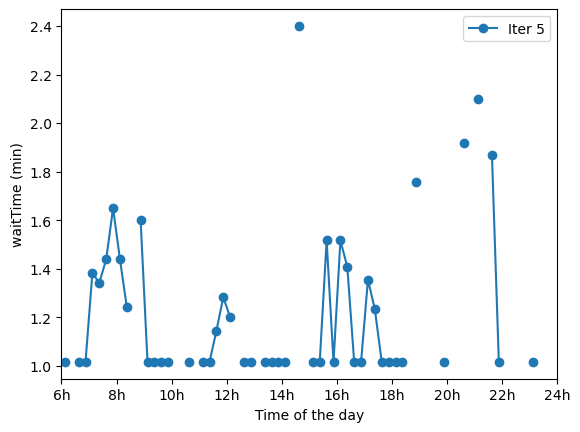

In [7]:
plot_column_by_time(drt_legs, 'waitTime', start_time=6, end_time=24, bin_duration_min=15)

In [8]:
def avg_by_euclidean_distance_bin(drt_legs, column, min_distance=0, max_distance=5000, bins_resolution=200):
    legs = drt_legs.copy()
    n_bins = (max_distance - min_distance) // bins_resolution
    distance_bins = [i*bins_resolution for i in range(n_bins + 1)]
    legs['euclidean_distance'] = np.sqrt((legs.fromX - legs.toX)**2 + (legs.fromY - legs.toY)**2)
    legs['distance_bin'] = pd.cut(legs.euclidean_distance, distance_bins).map(lambda x: int((x.left + x.right)/2))
    grouped = legs.groupby(['distance_bin'])[column].mean()
    return grouped

In [9]:
def plot_column_by_euclidean_distance(drt_legs, column, min_distance=0, max_distance=5000, bins_resolution=200, start_iter=None):
    n_iters = len(drt_legs)
    for it in range(start_iter if start_iter is not None else n_iters-1,n_iters):
        avg_by_bin = avg_by_euclidean_distance_bin(drt_legs[it], column, min_distance = min_distance, max_distance = max_distance,
                                        bins_resolution = bins_resolution)
        x = np.array(avg_by_bin.index.values)/1000
        plt.plot(x, avg_by_bin.values, 'o-', label='Iter ' + str(it))

    plt.xlabel('Euclidean distance (km)')
    plt.ylabel(column + ' (min)')
    plt.xticks(np.arange(min_distance/1000, max_distance/1000, 0.5))
    plt.legend()
    plt.show()

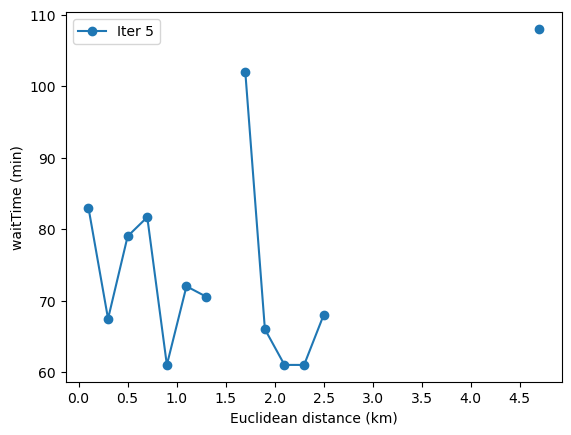

In [10]:
plot_column_by_euclidean_distance(drt_legs, 'waitTime')